# Задание 1. Информация об аминокислотах

In [118]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen as uReq
from urllib.request import Request
import lxml
import gzip
import io
import re 

In [124]:
url = "https://aminoacidsguide.com/"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 YaBrowser/24.1.0.0 Safari/537.36',
    'Referer': 'https://aminoacidsguide.com/'
}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', class_='smalltable')
data = []
for row in table.find_all('tr'):
    cols = row.find_all(['th', 'td'])
    cols = [col.text.strip() for col in cols]
    data.append(cols)
    df = pd.DataFrame(data[1:], columns=data[0])

In [125]:
df.head()

,Name,Three letter code,One letter code,Molecular\n Weight,Molecular\n Formula,Residue\n Formula,Residue Weight\n (-H2O),pKa,pKb,pKx,pl
0,Alanine,Ala,A,89.10,C3H7NO2,C3H5NO,71.08,2.34,9.69,–,6.00
1,Arginine,Arg,R,174.20,C6H14N4O2,C6H12N4O,156.19,2.17,9.04,12.48,10.76
2,Asparagine,Asn,N,132.12,C4H8N2O3,C4H6N2O2,114.11,2.02,8.80,–,5.41
3,Aspartic acid,Asp,D,133.11,C4H7NO4,C4H5NO3,115.09,1.88,9.60,3.65,2.77
4,Cysteine,Cys,C,121.16,C3H7NO2S,C3H5NOS,103.15,1.96,10.28,8.18,5.07


# Задание 2. Фильм на вечер

In [119]:
# Отправляем запрос к URL-адресу страницы IMDb
url = ('https://www.imdb.com/chart/top/?ref_=nv_mv_250')
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 YaBrowser/24.1.0.0 Safari/537.36',
    'Referer': 'https://www.imdb.com/',
    'Accept': '*/*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'ru,en;q=0.9',
    'Access-Control-Request-Method' : 'GET',
    'Access-Control-Request-Headers':'content-type,x-amzn-sessionid,x-imdb-client-name,x-imdb-client-rid,x-imdb-user-country,x-imdb-user-language,x-imdb-weblab-treatment-overrides',
    'Origin': 'https://www.imdb.com',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site'
}


In [120]:
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

In [121]:
# Получим названия фильмов
titles = [cell.text.strip() for cell in soup.find_all(class_='ipc-title__text')]
movie_titles = [title.split('.', 1)[1].strip() for title in titles if re.match(r'\d+\.', title)]

# Получим длительность и годы выпуска фильмов
years = []
durations = []
elements = soup.find_all(class_="sc-b189961a-8 kLaxqf cli-title-metadata-item")
for element in elements:
    text = element.get_text()  
    if re.search(r'\d{4}', text):  
        years.append(int(text))
    elif re.search(r'\d+h \d+m', text) or re.search(r'\d+h', text) or re.search(r'\d+m', text):  
        durations.append(text)

# Получим рейтинги фильмов
ratings =[]
for element in soup.find_all("span", attrs={"aria-label": lambda x: x.startswith("IMDb rating:") if x else False}):
    ratings.append(float(element.attrs["aria-label"].split(' ')[2]))

df = pd.DataFrame(
    {'title': movie_titles,
     'rank': list(range(1,251)),
     'year': years,
     'duration': durations,
     'rating': ratings
    })
df.head()

,title,rank,year,duration,rating
0,Die Verurteilten,1,1994,2h 22m,9.3
1,Der Pate,2,1972,2h 55m,9.2
2,The Dark Knight,3,2008,2h 32m,9.0
3,Der Pate 2,4,1974,3h 22m,9.0
4,Die zwölf Geschworenen,5,1957,1h 36m,9.0


In [122]:
# Отберем топ-4 года по среднему рейтингу фильмов
years = df.year.unique()
mean_ratings = []
for year in years:
    mean_ratings.append(df.query(f'year == {year}')[['rating']].mean(axis=0).iloc[0])
rating_df = pd.DataFrame(
    {'year': years,
     'rating': mean_ratings
    })
rating_df.sort_values('rating', ascending=False).head(4)

,year,rating
1,1972,9.2
0,1994,8.8
13,2024,8.8
20,1991,8.6


# Задание 3. Телеграмм-логгер

In [126]:
import sys
import time
import os
import sys
import io
import datetime
import requests
from functools import wraps
from dotenv import load_dotenv

exec(open("HW17_Internet.py").read())

In [127]:
import datetime
load_dotenv("tg.env")
chat_id = "1934656026"
TELEGRAM_API_URL = f"https://api.telegram.org/bot{os.getenv('TG_API_TOKEN')}/sendMessage"

# Функция для форматирования времени выполнения
def format_execution_time(start_time, end_time):
    execution_time = end_time - start_time
    if execution_time < datetime.timedelta(days=1):
        return str(execution_time)
    else:
        days = execution_time.days
        seconds = execution_time.seconds
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        return f"{days} days, {hours:02}:{minutes:02}:{seconds:02}"

# Декоратор telegram_logger
def telegram_logger(chat_id):
    def decorator(func):
        def wrapper(*args, **kwargs):
            start_time = datetime.datetime.now()

            try:
                result = func(*args, **kwargs)
                end_time = datetime.datetime.now()
                execution_time = format_execution_time(start_time, end_time)

                message = f"✅Function {func.__name__} executed successfully.\n"
                message += f"⏳Execution time: {execution_time}\n"
                send_telegram_message(chat_id, message, TELEGRAM_API_URL)

                return result
            except Exception as e:
                end_time = datetime.datetime.now()
                execution_time = format_execution_time(start_time, end_time)

                message = f"Function {func.__name__} encountered an error.\n"
                message += f"Error type: {type(e).__name__}\n"
                message += f"Error message: {str(e)}\n"
                message += f"Execution time: {execution_time}\n"
                send_telegram_message(chat_id, message, TELEGRAM_API_URL)
                raise

        return wrapper

    return decorator

# Функция для отправки сообщения в телеграм
def send_telegram_message(chat_id, message, url):
    data = {
        "chat_id": chat_id,
        "text": message
    }
    response = requests.post(url, data=data)
    if response.status_code != 200:
        print("Failed to send Telegram message.")
        print(response.text)

In [128]:
@telegram_logger(chat_id=chat_id)
def example_function():
    print("Привет")
    return

# Запуск примера функции
if __name__ == "__main__":
    example_function()

Привет


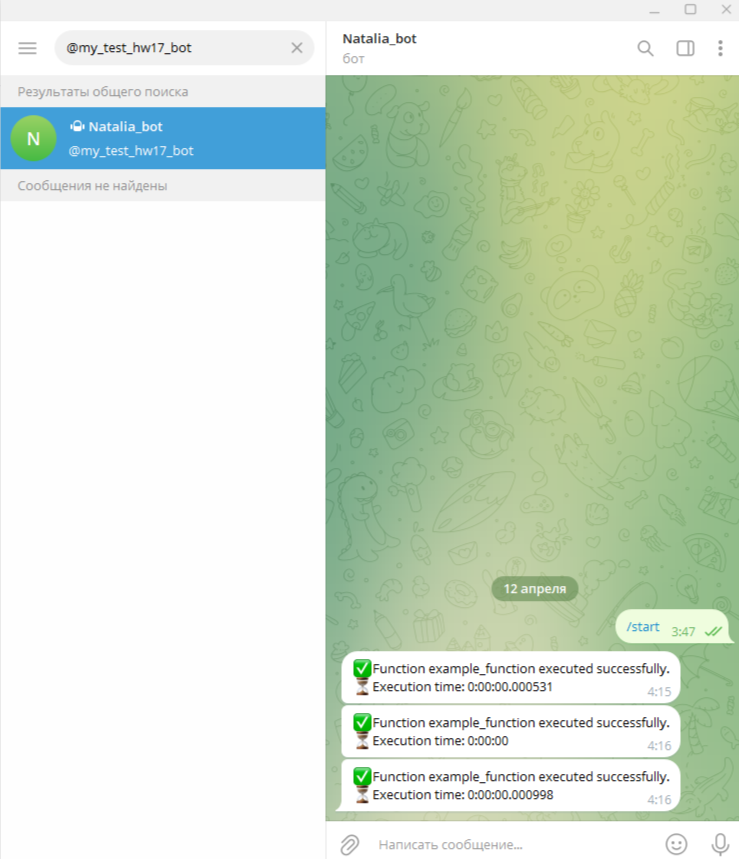